## ResNet Image Classification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time
import os
import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/cnn_dataset.zip'
!unzip '/content/drive/My Drive/cnn_dataset.zip' -d cnn_dataset

Streaming output truncated to the last 5000 lines.
  inflating: cnn_dataset/vehicles/5499.jpg  
  inflating: cnn_dataset/vehicles/55.jpg  
  inflating: cnn_dataset/vehicles/550.jpg  
  inflating: cnn_dataset/vehicles/5500.jpg  
  inflating: cnn_dataset/vehicles/5501.jpg  
  inflating: cnn_dataset/vehicles/5502.jpg  
  inflating: cnn_dataset/vehicles/5503.jpg  
  inflating: cnn_dataset/vehicles/5504.jpg  
  inflating: cnn_dataset/vehicles/5505.jpg  
  inflating: cnn_dataset/vehicles/5506.jpg  
  inflating: cnn_dataset/vehicles/5507.jpg  
  inflating: cnn_dataset/vehicles/5508.jpg  
  inflating: cnn_dataset/vehicles/5509.jpg  
  inflating: cnn_dataset/vehicles/551.jpg  
  inflating: cnn_dataset/vehicles/5510.jpg  
  inflating: cnn_dataset/vehicles/5511.jpg  
  inflating: cnn_dataset/vehicles/5512.jpg  
  inflating: cnn_dataset/vehicles/5513.jpg  
  inflating: cnn_dataset/vehicles/5514.jpg  
  inflating: cnn_dataset/vehicles/5515.jpg  
  inflating: cnn_dataset/vehicles/5516.jpg  
  inflat

In [ ]:
os.listdir('cnn_dataset')

['food', 'dogs', 'vehicles']

In [ ]:
dir = 'cnn_dataset'
def get_path_names(dir):
  images = []
  for path, subdirs, files in os.walk(dir):
    for name in files:
      #print(os.path.join(path, name))
      images.append(os.path.join(path, name))
  return images

In [ ]:
get_path_names(dir)

['cnn_dataset/food/9502.jpg',
 'cnn_dataset/food/8401.jpg',
 'cnn_dataset/food/3783.jpg',
 'cnn_dataset/food/2450.jpg',
 'cnn_dataset/food/2324.jpg',
 'cnn_dataset/food/761.jpg',
 'cnn_dataset/food/3025.jpg',
 'cnn_dataset/food/5076.jpg',
 'cnn_dataset/food/9162.jpg',
 'cnn_dataset/food/5569.jpg',
 'cnn_dataset/food/8766.jpg',
 'cnn_dataset/food/3552.jpg',
 'cnn_dataset/food/7645.jpg',
 'cnn_dataset/food/5257.jpg',
 'cnn_dataset/food/3091.jpg',
 'cnn_dataset/food/9822.jpg',
 'cnn_dataset/food/1387.jpg',
 'cnn_dataset/food/2348.jpg',
 'cnn_dataset/food/4144.jpg',
 'cnn_dataset/food/4641.jpg',
 'cnn_dataset/food/5545.jpg',
 'cnn_dataset/food/8067.jpg',
 'cnn_dataset/food/5200.jpg',
 'cnn_dataset/food/6740.jpg',
 'cnn_dataset/food/2181.jpg',
 'cnn_dataset/food/2108.jpg',
 'cnn_dataset/food/4728.jpg',
 'cnn_dataset/food/155.jpg',
 'cnn_dataset/food/7492.jpg',
 'cnn_dataset/food/4705.jpg',
 'cnn_dataset/food/4454.jpg',
 'cnn_dataset/food/3812.jpg',
 'cnn_dataset/food/7241.jpg',
 'cnn_datase

In [ ]:
classes_name = [os.listdir(dir)]
print(classes_name)

[['food', 'dogs', 'vehicles']]


In [ ]:
#Define size

size = 64

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255))
])


In [ ]:
dataset = torchvision.datasets.ImageFolder(root='cnn_dataset', transform=transform)

# Split train_dataset into train and validation
train_size = int(0.7 * len(dataset))
val_size = int(0.4 * (len(dataset)-train_size))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
print(train_dataset[22][1])

1


In [ ]:
len(dataset)

30000

In [ ]:
def helper_function(x, y):
  diff = x.shape[-1] - y.shape[-1]
  y = nn.functional.pad(y, (0, diff, 0, diff), mode='constant', value=0)
  return y

In [ ]:
class Building_block(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(Building_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv_str2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        inp_val = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.stride == 2:
            inp_val = self.conv_str2(inp_val)
            inp_val = self.bn3(inp_val)

        # Match dimension
        if inp_val is not None and inp_val.shape[-1] != x.shape[-1]:
            inp_val = helper_function(x, inp_val)
        x = x + inp_val
        x = self.relu(x)
        return x

class ResNet18(nn.Module):

    def __init__(self, img_channels, num_classes):

        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.softmax = nn.Softmax(dim=1)

        # Layer 1
        self.layer1 = nn.Sequential(
            Building_block(64, 64, stride=1),
            Building_block(64, 64)
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            Building_block(64, 128, stride=2),
            Building_block(128, 128)
        )

        # Layer 3
        self.layer3 = nn.Sequential(
            Building_block(128, 256, stride=2),
            Building_block(256, 256)
        )

        # Layer 4
        self.layer4 = nn.Sequential(
            Building_block(256, 512, stride=2),
            Building_block(512, 512)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ResNet18(3, 3).to(device)

In [ ]:
x = torch.randn(1,3, 64,64).to(device)
y = model(x)
print(y.shape)

torch.Size([1, 3])


In [ ]:
device

device(type='cuda', index=0)

Epoch 1/5, Train Loss: 0.4501, Train Accuracy: 0.8246
Epoch 2/5, Train Loss: 0.3254, Train Accuracy: 0.8766
Epoch 3/5, Train Loss: 0.2796, Train Accuracy: 0.8943
Epoch 4/5, Train Loss: 0.2470, Train Accuracy: 0.9092
Epoch 5/5, Train Loss: 0.2178, Train Accuracy: 0.9185
Precision: 0.8847
Recall: 0.8846
F1 Score: 0.8847


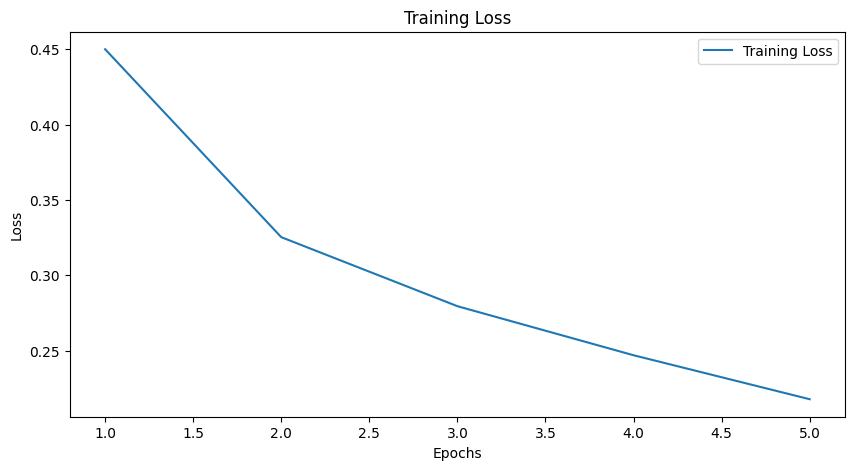

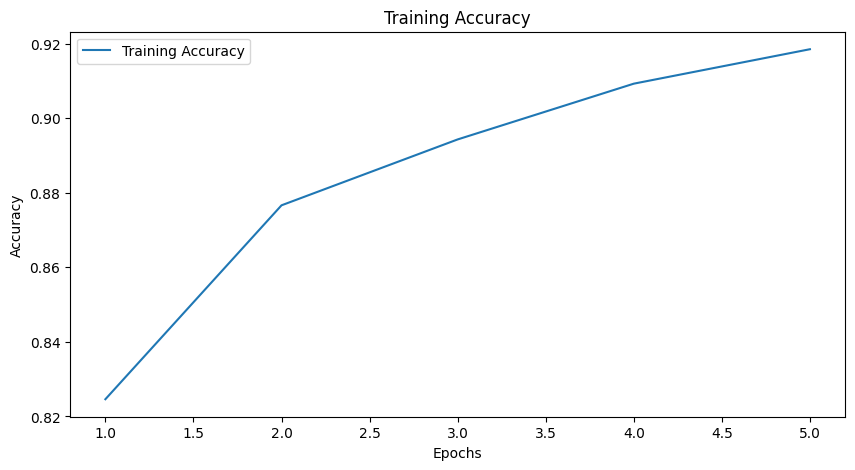

In [ ]:

criterion = nn.CrossEntropyLoss()
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    train_precision.append(epoch_precision)
    train_recall.append(epoch_recall)
    train_f1.append(epoch_f1)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")


print(f"Precision: {sum(train_precision)/len(train_precision):.4f}")
print(f"Recall: {sum(train_recall)/len(train_recall):.4f}")
print(f"F1 Score: {sum(train_f1)/len(train_f1):.4f}")

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


Epoch 1/5, Train Loss: 0.7791, Train Accuracy: 0.7670
Epoch 2/5, Train Loss: 0.7394, Train Accuracy: 0.8085
Epoch 3/5, Train Loss: 0.7262, Train Accuracy: 0.8217
Epoch 4/5, Train Loss: 0.7137, Train Accuracy: 0.8341
Epoch 5/5, Train Loss: 0.7032, Train Accuracy: 0.8449
Precision: 0.8155
Recall: 0.8152
F1 Score: 0.8152


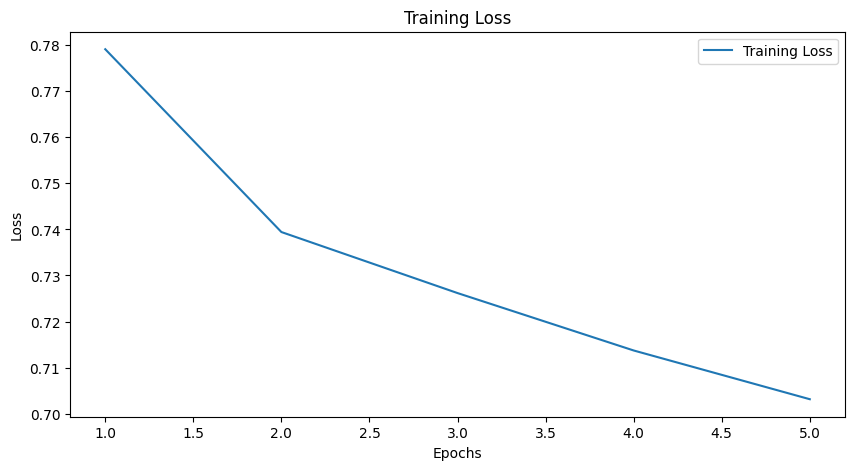

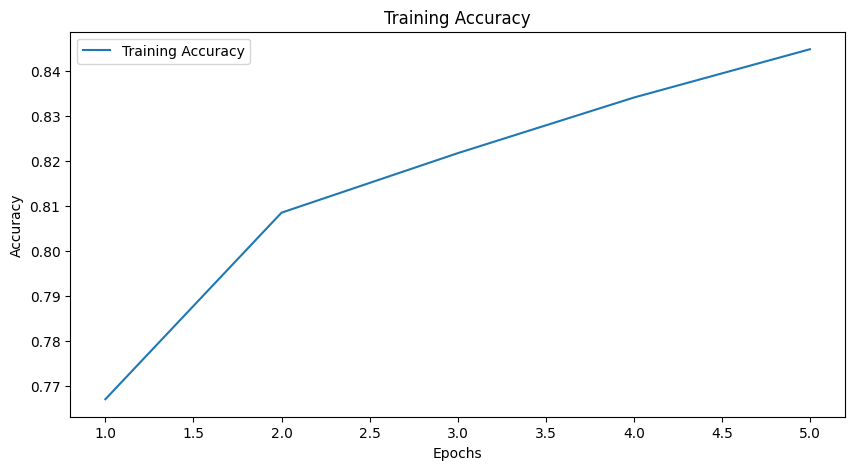

In [ ]:

criterion = nn.CrossEntropyLoss()
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    train_precision.append(epoch_precision)
    train_recall.append(epoch_recall)
    train_f1.append(epoch_f1)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")


print(f"Precision: {sum(train_precision)/len(train_precision):.4f}")
print(f"Recall: {sum(train_recall)/len(train_recall):.4f}")
print(f"F1 Score: {sum(train_f1)/len(train_f1):.4f}")

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


In [ ]:
val_losses = []
val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []

for epoch in range(epochs):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Iterate over the validation dataset
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Append metrics to lists
    val_losses.append(epoch_loss)
    val_accuracy.append(epoch_accuracy)
    val_precision.append(epoch_precision)
    val_recall.append(epoch_recall)
    val_f1.append(epoch_f1)

    # Print validation metrics
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_accuracy:.4f}")

# Print overall validation metrics
print(f"Validation Precision: {sum(val_precision)/len(val_precision):.4f}")
print(f"Validation Recall: {sum(val_recall)/len(val_recall):.4f}")
print(f"Validation F1 Score: {sum(val_f1)/len(val_f1):.4f}")

# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
test_losses = []
test_accuracy = []
test_precision = []
test_recall = []
test_f1 = []

for epoch in range(epochs):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Iterate over the test dataset
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Append metrics to lists
    test_losses.append(epoch_loss)
    test_accuracy.append(epoch_accuracy)
    test_precision.append(epoch_precision)
    test_recall.append(epoch_recall)
    test_f1.append(epoch_f1)

    # Print test metrics
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_accuracy:.4f}")

# Print overall test metrics
print(f"Test Precision: {sum(test_precision)/len(test_precision):.4f}")
print(f"Test Recall: {sum(test_recall)/len(test_recall):.4f}")
print(f"Test F1 Score: {sum(test_f1)/len(test_f1):.4f}")

# Plotting test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.show()

# Plotting test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS = 5
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_correct = 0
    train_total = 0
    train_loss = 0

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_accuracy = train_correct / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    val_correct = 0
    val_total = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

    # Testing
    test_correct = 0
    test_total = 0
    test_loss = 0

    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            preds_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = test_correct / test_total

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

conf_matrix = confusion_matrix(targets_list, preds_list)
print("Confusion Matrix:")
print(conf_matrix)
precision = precision_score(targets_list, preds_list, average='weighted')
recall = recall_score(targets_list, preds_list, average='weighted')
f1 = f1_score(targets_list, preds_list, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Confusion Matrix:
[[1400  291   91]
 [ 114 1555  150]
 [ 225  116 1458]]
Precision: 0.8185
Recall: 0.8172
F1 Score: 0.8172


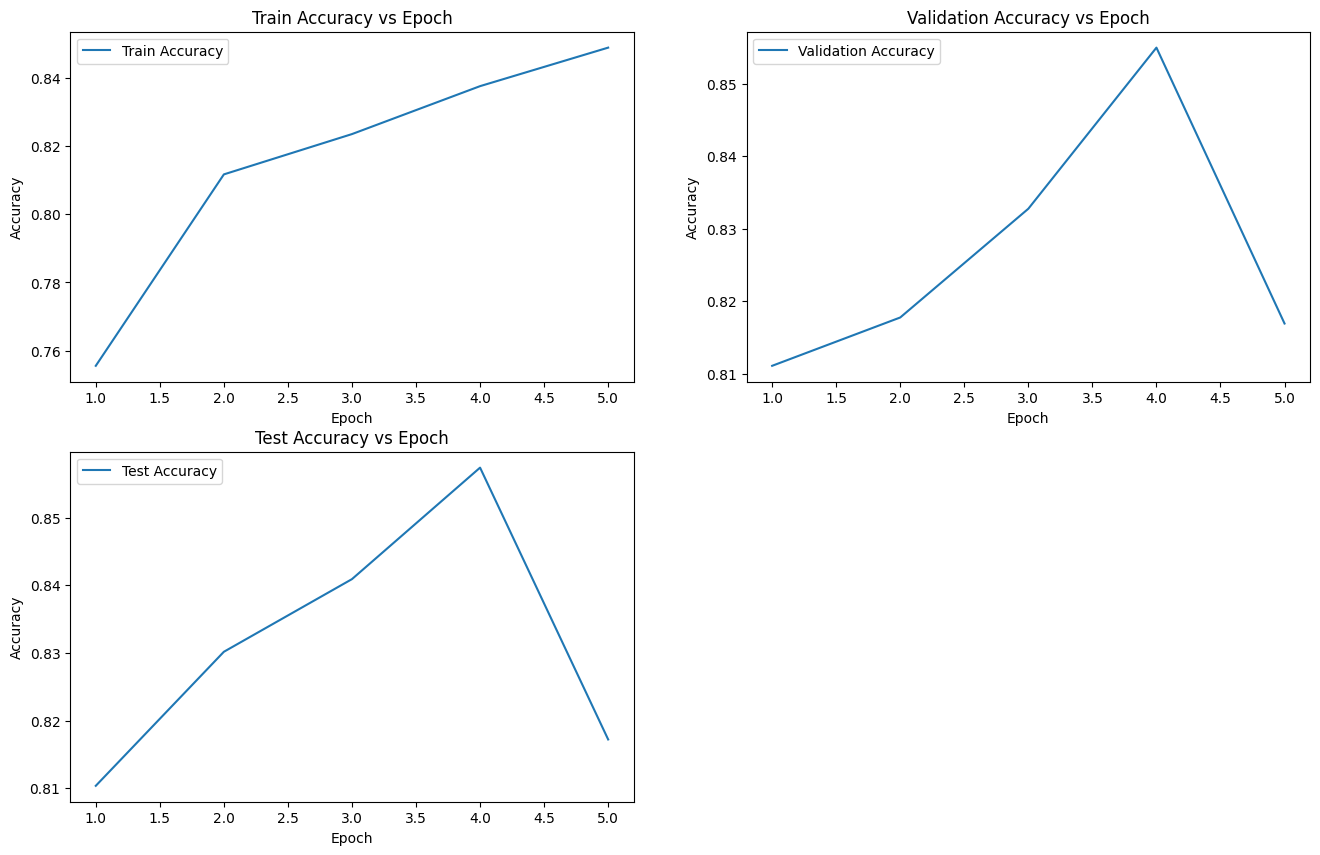

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()


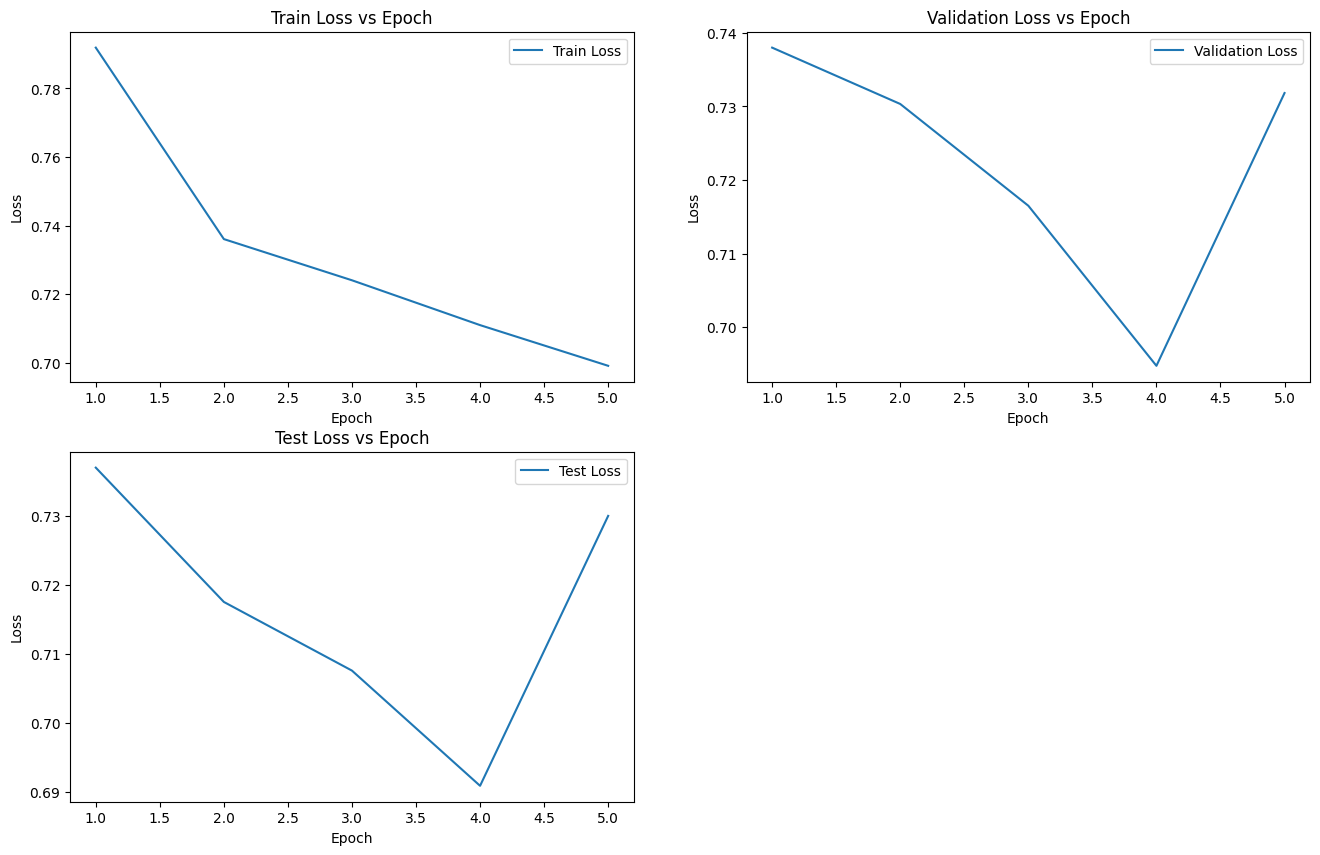

In [ ]:
# Plot train loss
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs Epoch')
plt.legend()

In [ ]:
#Print Accuracies:

print(f"Train Accuracies: {train_accuracies[-1]*100}%")
print(f"Validation Accuracies: {val_accuracies[-1]*100}%")
print(f"Test Accuracies: {test_accuracies[-1]*100}%")

Train Accuracies: 84.88095238095238%
Validation Accuracies: 81.69444444444444%
Test Accuracies: 81.72222222222221%


In [ ]:
#Print Loss:
print(f"Train Loss: {train_losses[-1]}")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Loss: 0.699107855842227
Validation Loss: 0.73182090388404
Test Loss: 0.7300489725889983


In [ ]:
torch.save(model.state_dict(), 'ResNet_basic.pth')

**Apply L2 Regularization**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
NUM_EPOCHS = 12
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_correct = 0
    train_total = 0
    train_loss = 0

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_accuracy = train_correct / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    val_correct = 0
    val_total = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

    # Testing
    test_correct = 0
    test_total = 0
    test_loss = 0

    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            preds_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = test_correct / test_total

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

conf_matrix = confusion_matrix(targets_list, preds_list)
print("Confusion Matrix:")
print(conf_matrix)
precision = precision_score(targets_list, preds_list, average='weighted')
recall = recall_score(targets_list, preds_list, average='weighted')
f1 = f1_score(targets_list, preds_list, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Confusion Matrix:
[[1480  135  167]
 [ 132 1615   72]
 [  46   57 1696]]
Precision: 0.8876
Recall: 0.8872
F1 Score: 0.8867


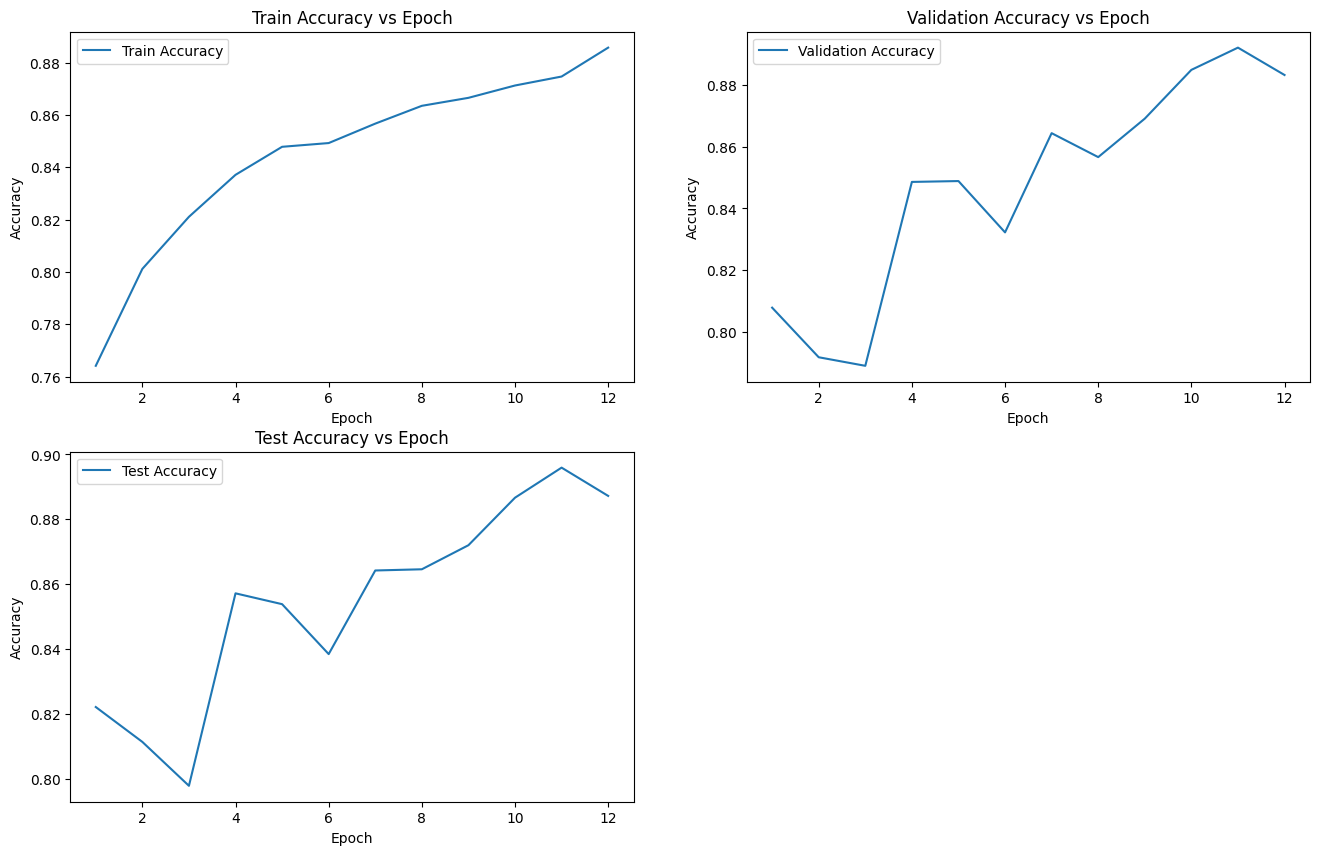

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()


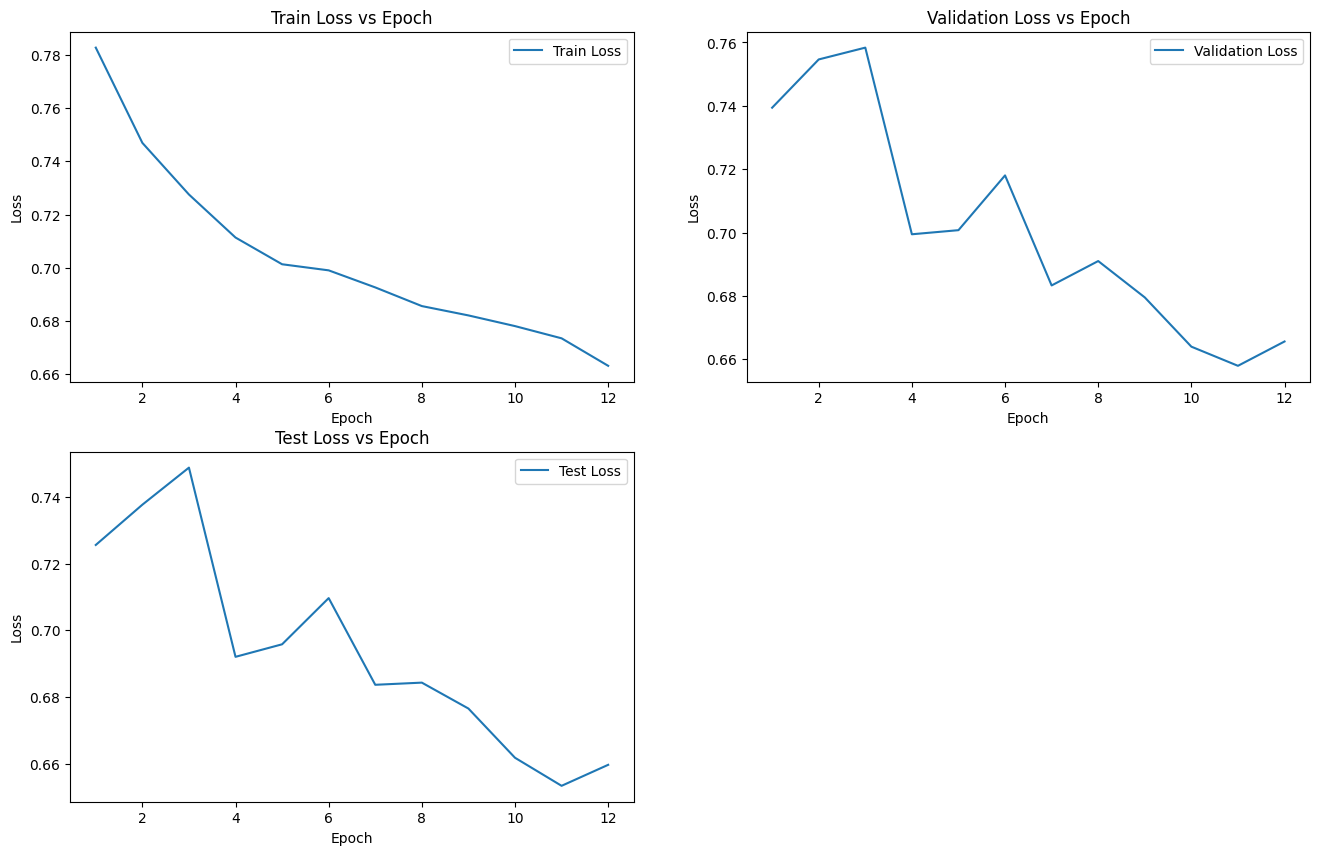

In [ ]:
# Plot train loss
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs Epoch')
plt.legend()

In [ ]:
#Print Accuracies:

print(f"Train Accuracies: {train_accuracies[-1]*100}%")
print(f"Validation Accuracies: {val_accuracies[-1]*100}%")
print(f"Test Accuracies: {test_accuracies[-1]*100}%")

Train Accuracies: 88.57619047619048%
Validation Accuracies: 88.33333333333333%
Test Accuracies: 88.72222222222223%


In [ ]:
#Print Loss:
print(f"Train Loss: {train_losses[-1]}")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Loss: 0.6632020957583473
Validation Loss: 0.6656107680002848
Test Loss: 0.6597307134557653


In [ ]:
torch.save(model.state_dict(), 'ResNet_l2.pth')

In [ ]:
dropout_prob = 0.2

**Batch Normalization**

In [ ]:
class Building_block(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(Building_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch Normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch Normalization
        self.conv_str2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn3 = nn.BatchNorm2d(out_channels)  # Batch Normalization
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        inp_val = x

        x = self.conv1(x)
        x = self.bn1(x)  # Batch Normalization
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Batch Normalization

        if self.stride == 2:
            inp_val = self.conv_str2(inp_val)
            inp_val = self.bn3(inp_val)  # Batch Normalization

        # Match dimension
        if inp_val is not None and inp_val.shape[-1] != x.shape[-1]:
            inp_val = helper_function(x, inp_val)
        x = x + inp_val
        x = self.relu(x)
        return x

class ResNet18(nn.Module):

    def __init__(self, img_channels, num_classes):

        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.softmax = nn.Softmax(dim=1)

        # Layer 1
        self.layer1 = nn.Sequential(
            Building_block(64, 64, stride=1),
            Building_block(64, 64)
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            Building_block(64, 128, stride=2),
            Building_block(128, 128)
        )

        # Layer 3
        self.layer3 = nn.Sequential(
            Building_block(128, 256, stride=2),
            Building_block(256, 256)
        )

        # Layer 4
        self.layer4 = nn.Sequential(
            Building_block(256, 512, stride=2),
            Building_block(512, 512)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)  # Batch Normalization
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS = 8
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_correct = 0
    train_total = 0
    train_loss = 0

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_accuracy = train_correct / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    val_correct = 0
    val_total = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

    # Testing
    test_correct = 0
    test_total = 0
    test_loss = 0

    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            preds_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = test_correct / test_total

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

conf_matrix = confusion_matrix(targets_list, preds_list)
print("Confusion Matrix:")
print(conf_matrix)
precision = precision_score(targets_list, preds_list, average='weighted')
recall = recall_score(targets_list, preds_list, average='weighted')
f1 = f1_score(targets_list, preds_list, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Confusion Matrix:
[[1582  147   53]
 [ 158 1618   43]
 [  86   58 1655]]
Precision: 0.8998
Recall: 0.8991
F1 Score: 0.8993


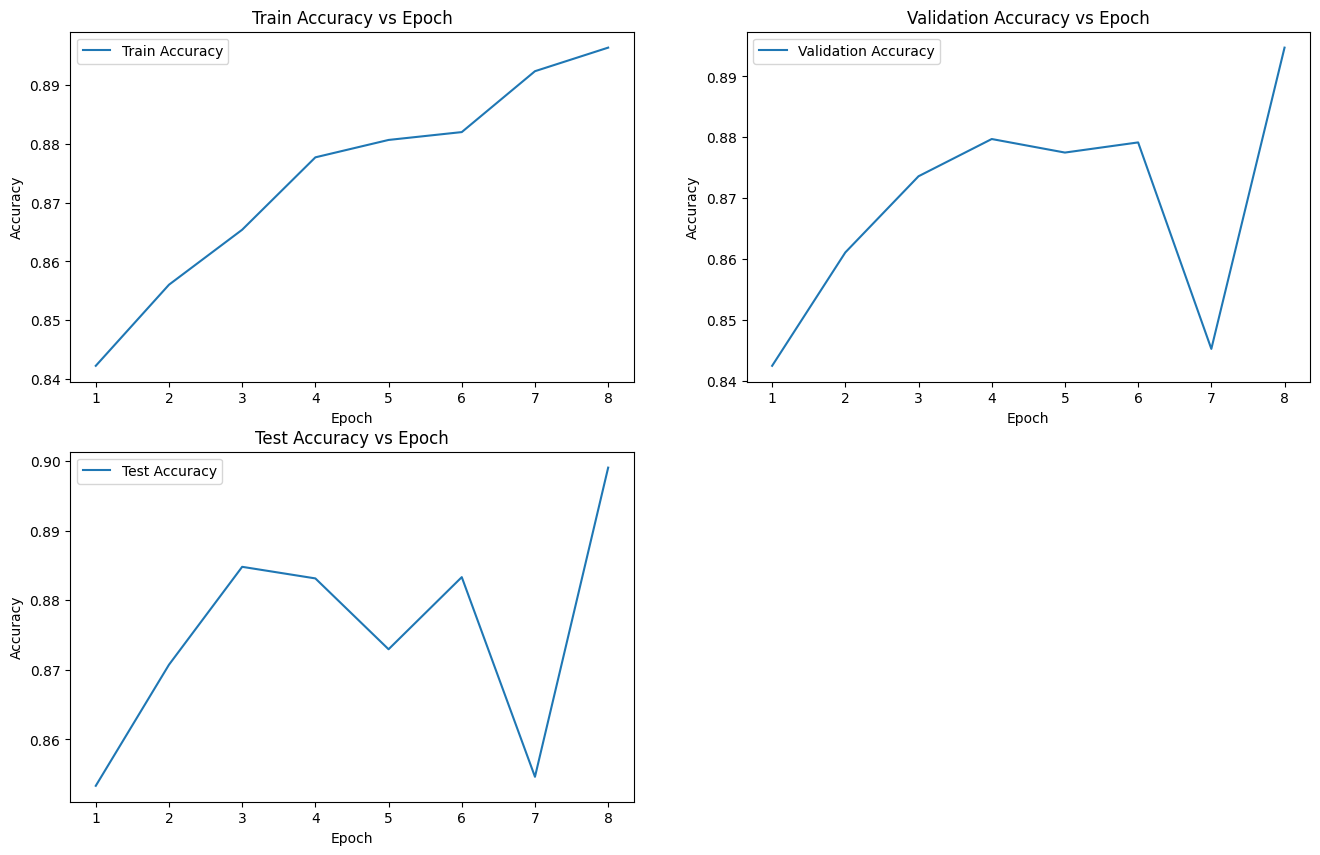

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()


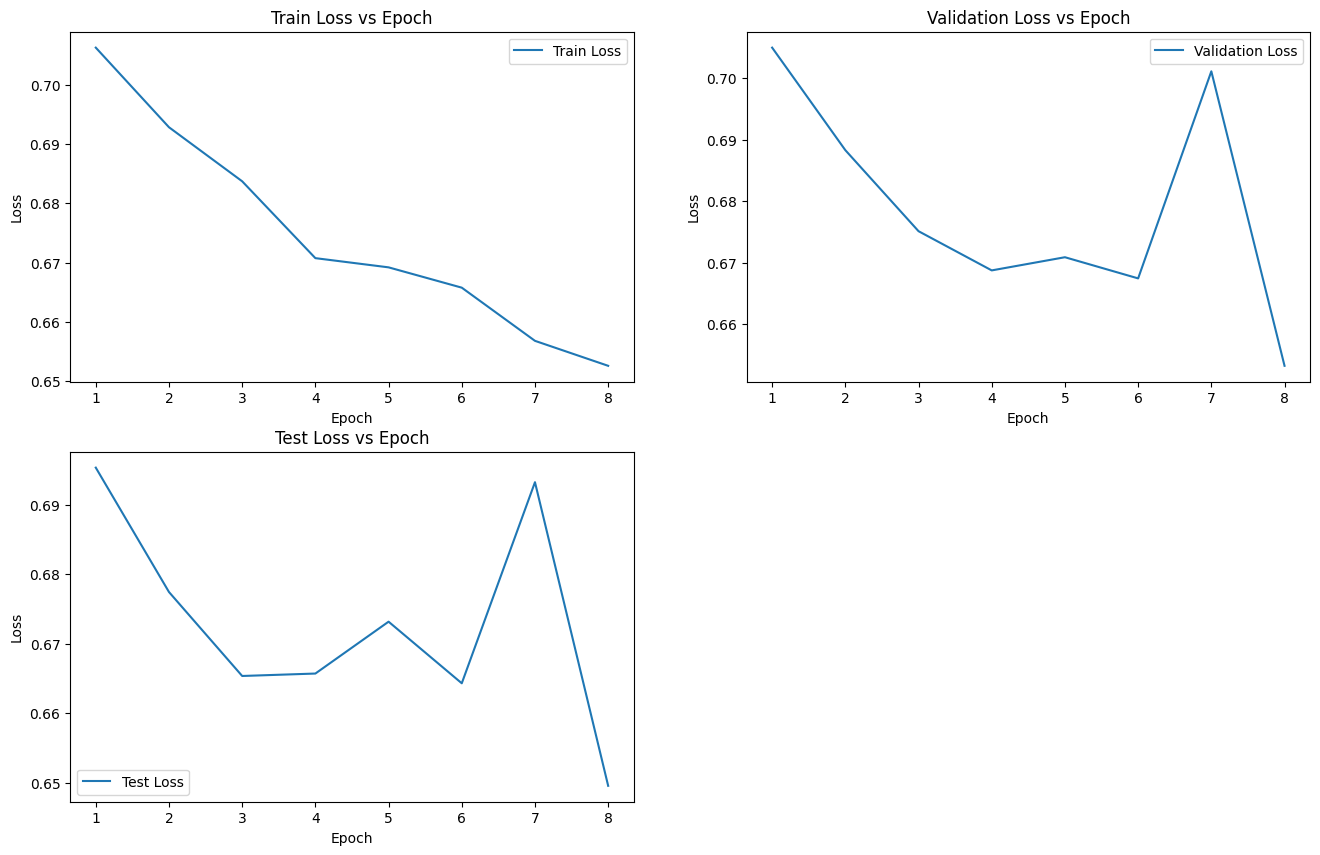

In [ ]:
# Plot train loss
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs Epoch')
plt.legend()

In [ ]:
#Print Accuracies:

print(f"Train Accuracies: {train_accuracies[-1]*100}%")
print(f"Validation Accuracies: {val_accuracies[-1]*100}%")
print(f"Test Accuracies: {test_accuracies[-1]*100}%")

Train Accuracies: 89.62857142857142%
Validation Accuracies: 89.47222222222221%
Test Accuracies: 89.9074074074074%


In [ ]:
#Print Loss:
print(f"Train Loss: {train_losses[-1]}")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Loss: 0.6525589999925523
Validation Loss: 0.6532533815171984
Test Loss: 0.6495481295055813


In [ ]:
torch.save(model.state_dict(), 'ResNet_bn.pth')

In [ ]:
from google.colab import files
files.download('ResNet_l2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('ResNet_bn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>